In [1]:
# import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import math

# Check the version of TensorFlow Decision Forests
# print('Found TF-DF v' + tfdf.__version__)

In [2]:
dataset_df = pd.read_json("./data/all_ads_small.json")
dataset_df.head(5)

,category,fuel_cb,gearbox_cb,id,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,Osobní,Nafta,Automatická,152780061,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,Osobní,Nafta,Manuální,152768137,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,Osobní,Nafta,None,152434055,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,Osobní,Nafta,Automatická,152415752,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,Osobní,Hybridní,Automatická,152255217,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1


In [3]:
dataset_df.describe()

,id,price,tachometer,vehicle_age
count,7.895000e+03,7.895000e+03,7.895000e+03,7895.000000
mean,1.689364e+08,6.121020e+05,1.069740e+05,7.216339
std,1.837222e+07,8.741781e+05,8.839429e+04,6.574518
min,6.875810e+07,1.000000e+04,0.000000e+00,-1.000000
25%,1.702701e+08,1.600000e+05,2.375000e+04,2.000000
50%,1.744093e+08,3.670000e+05,1.004820e+05,6.000000
75%,1.775209e+08,7.290000e+05,1.693175e+05,12.000000
max,1.792726e+08,2.305500e+07,1.145900e+06,66.000000


In [4]:
# Build the dataframe for train data
dataset_df = dataset_df.drop(["id", "category"], axis=1)

train_numerical = dataset_df.select_dtypes(exclude=["object"])
train_numerical.fillna(0, inplace=True)
train_categoric = dataset_df.select_dtypes(include=["object"])
train_categoric.fillna("NONE", inplace=True)
train = train_numerical.merge(train_categoric, left_index=True, right_index=True)


In [5]:
# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(max_samples=100, random_state=42)
# clf.fit(train_numerical)
# y_noano = clf.predict(train_numerical)
# y_noano = pd.DataFrame(y_noano, columns=["Top"])
# y_noano[y_noano["Top"] == 1].index.values
# train_numerical = train_numerical.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train_numerical.reset_index(drop=True, inplace=True)
# train_categoric = train_categoric.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train_categoric.reset_index(drop=True, inplace=True)
# train = train.iloc[y_noano[y_noano["Top"] == 1].index.values]
# train.reset_index(drop=True, inplace=True)


In [6]:
train.head()

,price,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb
0,1349000,26000,1,Nafta,Automatická,Středočeský kraj,BMW,Řada 3
1,455000,193107,5,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3
2,1510000,12000,1,Nafta,NONE,Jihočeský kraj,BMW,Řada 3
3,1228149,25400,1,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3
4,1703000,24000,1,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3


In [7]:
from sklearn.preprocessing import MinMaxScaler

col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)
col_train_cat = list(train_categoric.columns)
col_train_num_bis.remove("price")
mat_train = np.matrix(train_numerical)
mat_new = np.matrix(train_numerical.drop("price", axis=1))
mat_y = np.array(train.price)
prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(mat_y.size, 1))
prepro = MinMaxScaler()
prepro.fit(mat_train)
prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)
train_num_scale = pd.DataFrame(prepro.transform(mat_train), columns=col_train_num)
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train), columns=col_train_num)


/Users/adam.pavlat@rossum.ai/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/adam.pavlat@rossum.ai/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/adam.pavlat@rossum.ai/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more 

In [8]:
from sklearn.model_selection import train_test_split

COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "price"
FEATURES_CAT = col_train_cat

engineered_features = [tf.feature_column.numeric_column(key, shape=()) for key in FEATURES]

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.feature_column.categorical_column_with_hash_bucket(categorical_feature, hash_bucket_size=5000)

    engineered_features.append(
        tf.feature_column.embedding_column(
            sparse_column, dimension=16, combiner="sqrtn"
        )
    )


In [9]:
# Build the training set and the prediction set
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.price
# Split the train and prediction sets into test train sets
x_train, x_test, y_train, y_test = train_test_split(
    training_set[FEATURES + FEATURES_CAT],
    prediction_set,
    test_size=0.1,
    random_state=42,
)
y_train = pd.DataFrame(y_train, columns=[LABEL])
training_set = pd.DataFrame(x_train, columns=FEATURES + FEATURES_CAT).merge(
    y_train, left_index=True, right_index=True
)
y_test = pd.DataFrame(y_test, columns=[LABEL])
testing_set = pd.DataFrame(x_test, columns=FEATURES + FEATURES_CAT).merge(
    y_test, left_index=True, right_index=True
)


In [10]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)


def input_fn_new(data_set, training=True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}

    categorical_cols = {
        k: tf.SparseTensor(
            indices=[[i, 0] for i in range(data_set[k].size)],
            values=data_set[k].values,
            dense_shape=[data_set[k].size, 1],
        )
        for k in FEATURES_CAT
    }
    # Combines the dictionaries of the categorical and continuous features
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))

    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)
        # Outputs the feature columns and labels
        return feature_cols, label

    return feature_cols


# Builds the Model Framework
regressor = tf.estimator.LinearRegressor(
    feature_columns=engineered_features,
#     activation_fn=tf.nn.relu,
#     hidden_units=[125, 25],
)
categorical_cols = {
    k: tf.SparseTensor(
        indices=[[i, 0] for i in range(training_set[k].size)],
        values=training_set[k].values,
        dense_shape=[training_set[k].size, 1],
    )
    for k in FEATURES_CAT
}


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Metal device set to: Apple M1


2022-09-26 21:50:13.751791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 21:50:13.751898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
regressor.train(input_fn=lambda: input_fn_new(training_set), steps=5000)


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2022-09-26 21:50:14.332506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 21:50:14.332522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-26 21:50:14.340314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-26 21:50:14.353950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 21:50:14.356420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:50:14.384620: I tensorflow/core/grappler/optimizers/custom_graph

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2022-09-26 21:50:14.870332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:50:14.950556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:loss = 0.0020333095, step = 0


2022-09-26 21:50:15.192086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:global_step/sec: 94.91
INFO:tensorflow:loss = 0.0010610735, step = 100 (1.054 sec)
INFO:tensorflow:global_step/sec: 108.539
INFO:tensorflow:loss = 0.0009811276, step = 200 (0.921 sec)
INFO:tensorflow:global_step/sec: 107.485
INFO:tensorflow:loss = 0.0009396617, step = 300 (0.930 sec)
INFO:tensorflow:global_step/sec: 107.545
INFO:tensorflow:loss = 0.0009305736, step = 400 (0.930 sec)
INFO:tensorflow:global_step/sec: 107.579
INFO:tensorflow:loss = 0.0009261404, step = 500 (0.930 sec)
INFO:tensorflow:global_step/sec: 106.398
INFO:tensorflow:loss = 0.00092181354, step = 600 (0.940 sec)
INFO:tensorflow:global_step/sec: 106.169
INFO:tensorflow:loss = 0.00091590744, step = 700 (0.942 sec)
INFO:tensorflow:global_step/sec: 105.818
INFO:tensorflow:loss = 0.00090650964, step = 800 (0.945 sec)
INFO:tensorflow:global_step/sec: 106.225
INFO:tensorflow:loss = 0.0008911636, step = 900 (0.941 sec)
INFO:tensorflow:global_step/sec: 105.723
INFO:tensorflow:loss = 0.00086741115, step = 1000

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-26T21:51:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.17109s
INFO:tensorflow:Finished evaluation at 2022-09-26-21:51:06
INFO:tensorflow:Saving dict for global step 5000: average_loss = 0.0012659627, global_step = 5000, label/mean = 0.026831038, loss = 0.0012659627, prediction/mean = 0.02674023
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt-5000
Final Loss on the testing set: 0.001266


2022-09-26 21:51:06.488785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 21:51:06.488803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-26 21:51:06.507141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:06.522067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:06.533031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:06.54

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-26T21:51:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.16369s
INFO:tensorflow:Finished evaluation at 2022-09-26-21:51:07
INFO:tensorflow:Saving dict for global step 5000: average_loss = 0.0012659627, global_step = 5000, label/mean = 0.026831038, loss = 0.0012659627, prediction/mean = 0.02674023
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt-5000
Final Loss on the testing set: 0.001266
INFO:tensorflow:Calling model_fn.


2022-09-26 21:51:06.978127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 21:51:06.978143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-26 21:51:06.994939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.007763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.018371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.02

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8c/dvncxl8n0733h0fz370kj7j80000gp/T/tmp_q3g00us/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2022-09-26 21:51:07.300425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 21:51:07.300442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-26 21:51:07.316279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.330780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.341711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-26 21:51:07.34

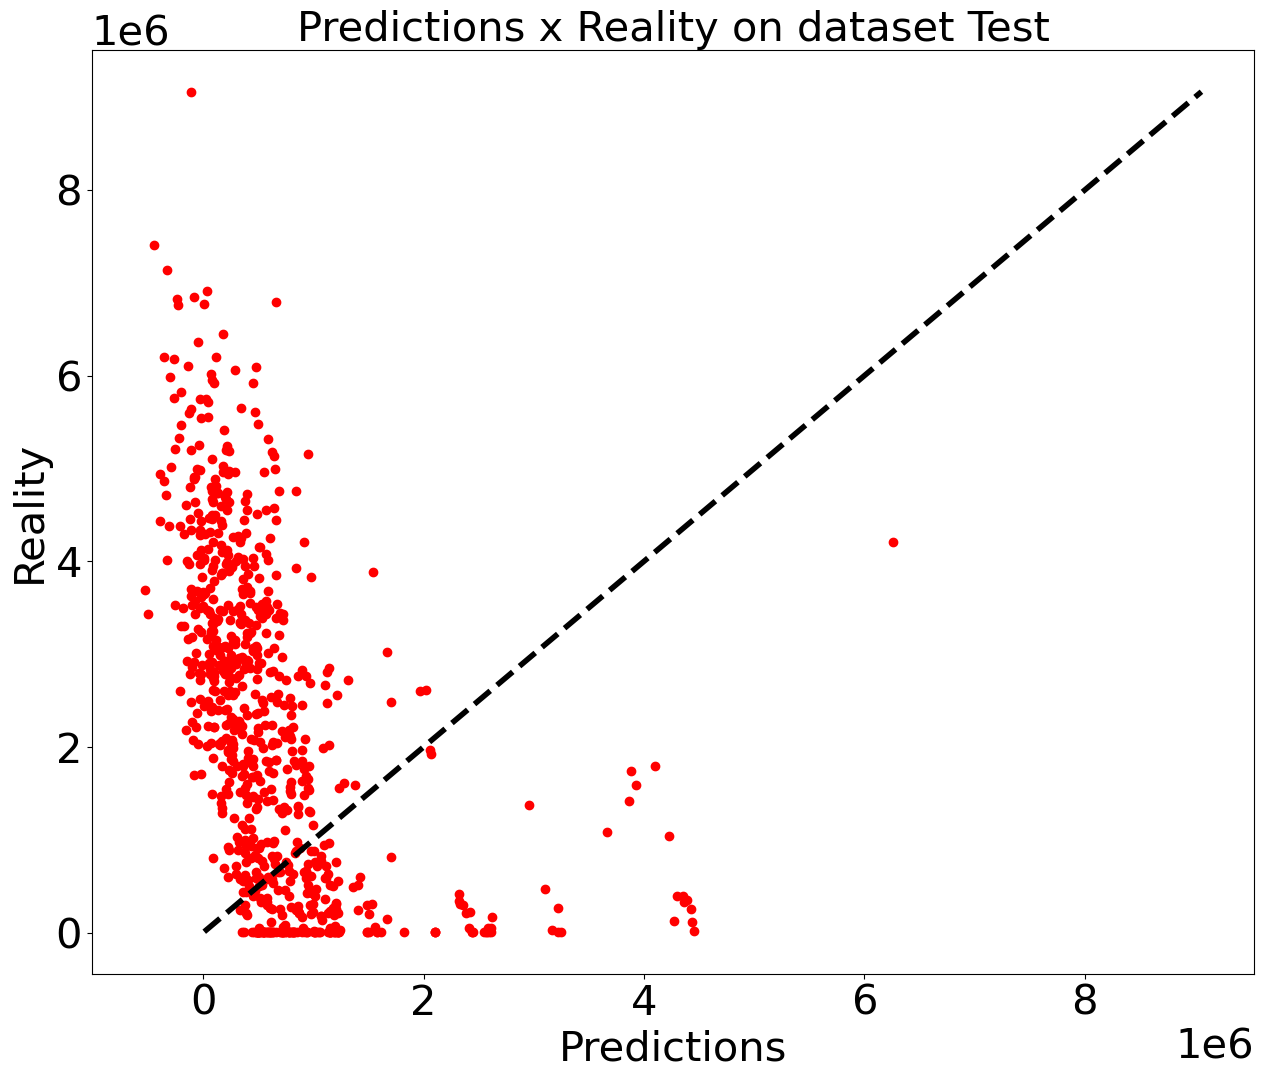

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import itertools

ev = regressor.evaluate(
    input_fn=lambda: input_fn_new(testing_set, training=True), steps=1
)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))

ev = regressor.evaluate(
    input_fn=lambda: input_fn_new(testing_set, training=True), steps=1
)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))

reality = pd.DataFrame(
    prepro.inverse_transform(testing_set.select_dtypes(exclude=["object"])),
    columns=[COLUMNS],
).price


y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions_all = list(itertools.islice(y, testing_set.shape[0]))
predictions = [prediction["predictions"] for prediction in predictions_all]

predictions_array = np.array(predictions).astype(float)
predictions = pd.DataFrame(
    prepro_y.inverse_transform(predictions_array.reshape(predictions_array.size, 1))
)

# reality.to_json('res-reality.json')
# predictions.to_json('res-predictions.json')

matplotlib.rc("xtick", labelsize=30)
matplotlib.rc("ytick", labelsize=30)
fig, ax = plt.subplots(figsize=(15, 12))
# plt.style.use("ggplot")
plt.plot(predictions.values, reality.values, "ro")
plt.xlabel("Predictions", fontsize=30)
plt.ylabel("Reality", fontsize=30)
plt.title("Predictions x Reality on dataset Test", fontsize=30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], "k--", lw=4)
plt.show()
